TokaMaker Example: Simple voltage coil evolution in HBT-EP {#doc_tMaker_HBT_ex3}
==========
In this example we show how to use voltage-specified coils

This example utilizes the mesh built in \ref doc_tMaker_HBT_ex1.

**Note:** Running this example requires the [h5py](https://www.h5py.org/) python package, which is installable using `pip` or other standard methods.

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

## Load TokaMaker library

To load the TokaMaker python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or using within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` on macOS).

For meshing we will use the \ref OpenFUSIONToolkit.TokaMaker.gs_Domain "gs_Domain()" class to build a 2D triangular grid suitable for Grad-Shafranov equilibria. This class uses the [triangle code](https://www.cs.cmu.edu/~quake/triangle.html) through a [python wrapper](https://pypi.org/project/triangle/).

In [2]:
tokamaker_python_path = '/Users/hansec/Research/OpenFUSIONToolkit/install_debug' #os.getenv('OFT_ROOTPATH')
if tokamaker_python_path is not None:
    sys.path.append(os.path.join(tokamaker_python_path,'python'))
from OpenFUSIONToolkit.TokaMaker import TokaMaker
from OpenFUSIONToolkit.TokaMaker.meshing import load_gs_mesh
from OpenFUSIONToolkit.TokaMaker.util import create_power_flux_fun

## Compute equilibria

### Initialize TokaMaker object
First we create a TokaMaker instance to use for equilibrium calculations. Note at present only a single instance can be used per python kernel, so this command should only be called **once** in a given Jupyter notebook or python script. In the future this restriction may be relaxed.

In [3]:
mygs = TokaMaker(nthreads=2)

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   tMaker_vcoils
Revision id:          d3b8acc
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------



### Load mesh into TokaMaker
Now we load the mesh generated in \ref doc_tMaker_HBT_ex1 using \ref OpenFUSIONToolkit.TokaMaker.load_gs_mesh "load_gs_mesh()" and \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup_mesh "setup_mesh()". Then we use \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup_regions "setup_regions()" to define the different region types. Finally, we call \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup "setup()" to setup the required solver objects. During this call we can specify the desired element order (min=2, max=4) and the toroidal field through F0 = B0*R0, where B0 is the toroidal field at a reference location R0.

In [4]:
mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict = load_gs_mesh('HBT_mesh.h5')
mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict,coil_dict=coil_dict)
mygs.setup(order = 2, F0=0.2518*1.23) # F0 = B0 * R0


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  3.278E+00
    # of points  =    3736
    # of edges   =   11087
    # of cells   =    7352
    # of boundary points =     118
    # of boundary edges  =     118
    # of boundary cells  =     118
  Resolution statistics:
    hmin =  1.959E-04
    hrms =  3.418E-02
    hmax =  9.532E-02
  Surface grounded at vertex     804


**** Creating Lagrange FE space
  Order  =    2
  Minlev =   -1

 Computing flux BC matrix 
 Inverting real matrix
   Time =    1.0549999999999999E-003


At line 6352 of file /Users/hansec/Research/OpenFUSIONToolkit/src/physics/grad_shaf.F90
Fortran runtime warning: An array temporary was created for argument 'b' of procedure 'mat_add_values'
At line 6356 of file /Users/hansec/Research/OpenFUSIONToolkit/src/physics/grad_shaf.F90
Fortran runtime warning: An array temporary was created for argument 'b' of procedure 'mat_add_values'


   1  2.6592E-03


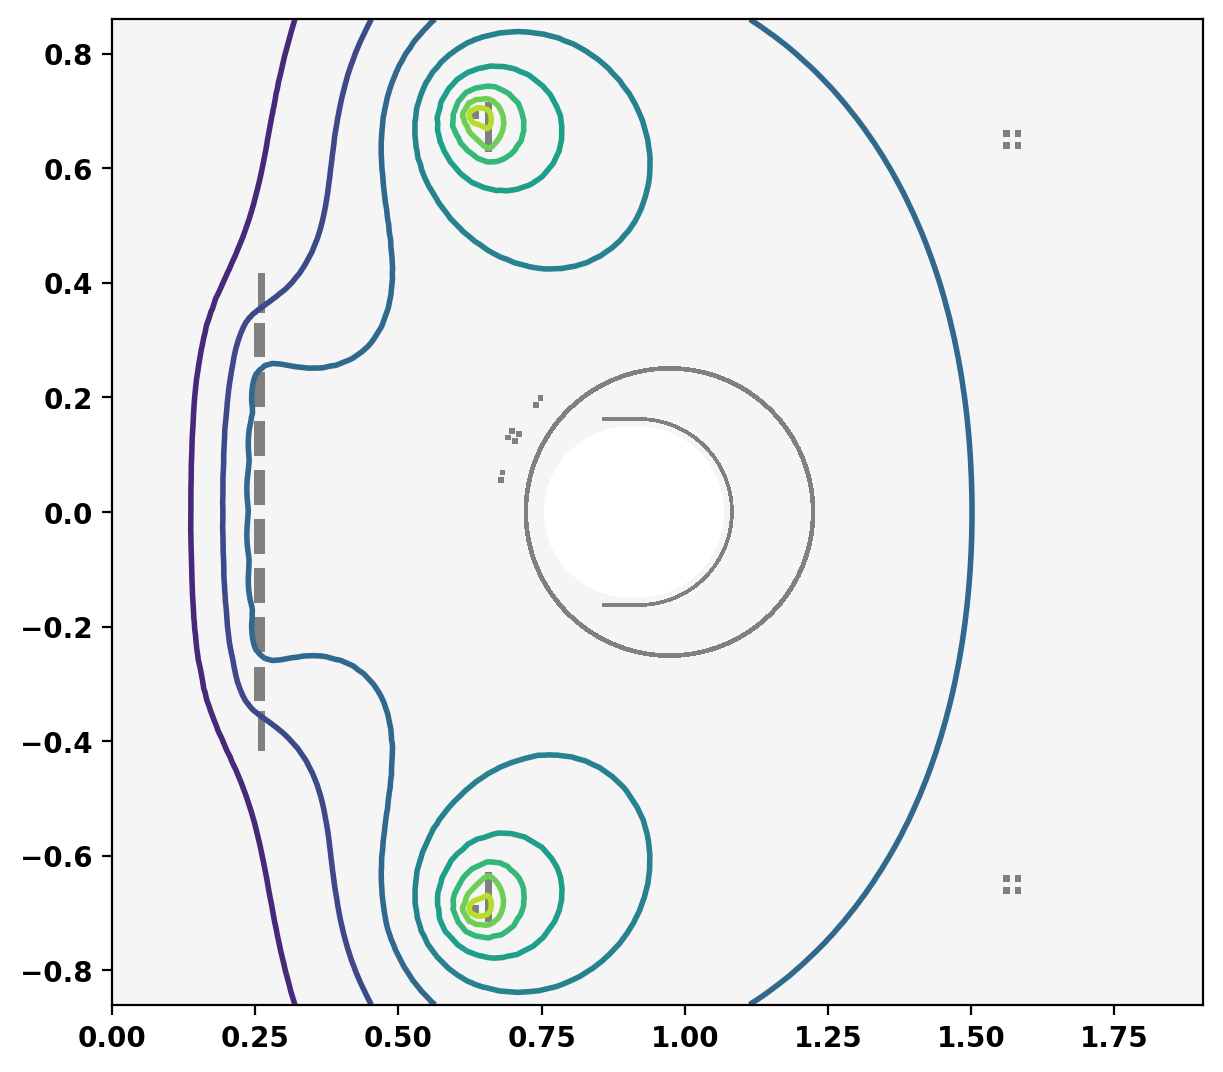

In [5]:
coil_currents = np.zeros((mygs.ncoils,))
coil_currents[mygs.coil_sets['OH']['id']] = 1.E3
mygs.set_coil_currents(coil_currents)
#
psi_vac, _ = mygs.vac_solve()
#
fig, ax = plt.subplots(1,1,constrained_layout=True)
# Plot flux evolution in time
mygs.plot_machine(fig,ax,coil_colormap=None,limiter_color=None)
mygs.plot_psi(fig,ax,psi=psi_vac,normalized=False,plasma_nlevels=10,vacuum_levels=None,xpoint_color=None)

In [6]:
rcoils = -np.ones((mygs.ncoils+1,))
coils_volt = np.zeros((mygs.ncoils+1,))
rcoils[mygs.coil_sets['OH']['id']] = 10.E-3
rcoils[mygs.coil_sets['VF']['id']] = 10.E-3
coils_volt[mygs.coil_sets['OH']['id']] = 5.0
#
dt=1.E-3
mygs.settings.pm=False
mygs.update_settings()
new_coil_currents, _ = mygs.get_coil_currents()
psi_new = psi_vac.copy()
coil_hist = [new_coil_currents,]
for i in range(160):
    mygs.set_psi_dt(psi_new,dt,rcoils,new_coil_currents,coils_volt)
    psi_new, _ = mygs.vac_solve()
    new_coil_currents, _ = mygs.get_coil_currents()
    coil_hist.append(new_coil_currents)
coil_hist = np.array(coil_hist)
mygs.settings.pm=True
mygs.update_settings()

In [7]:
Lmat = mygs.get_coil_Lmat()[:-1,:-1]
Rmat=np.diag(rcoils[:-1])
#
new_coil_simple = coil_hist[0].copy()
analytic_op = np.linalg.inv(Lmat+dt*Rmat)
coil_hist_simple = [new_coil_simple,]
for i in range(160):
    new_coil_simple = np.dot(analytic_op,dt*coils_volt[:-1]+np.dot(Lmat,new_coil_simple))
    coil_hist_simple.append(new_coil_simple)
coil_hist_simple = np.array(coil_hist_simple)

 Starting LU solver: umfpack F


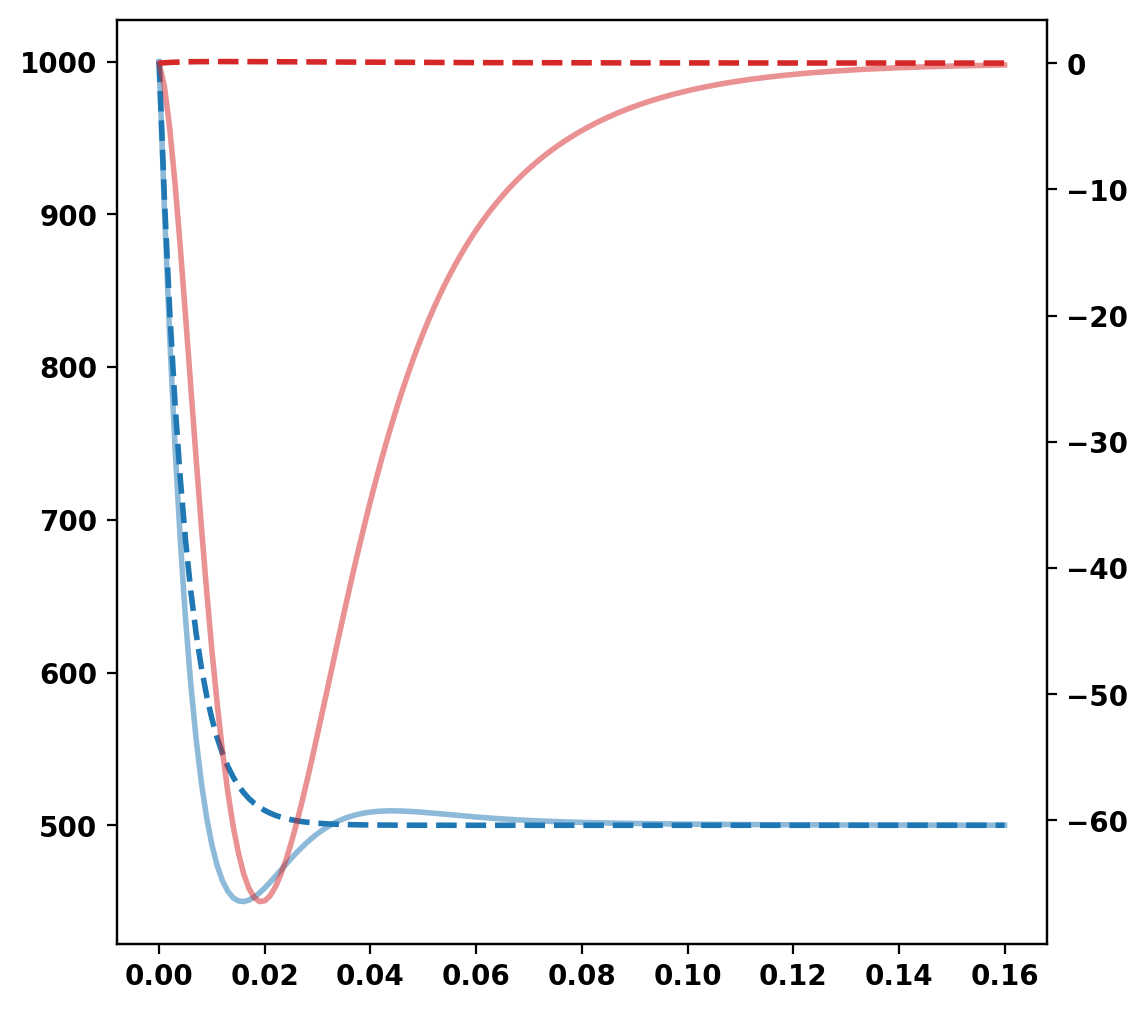

In [10]:
fig, ax = plt.subplots(1,1)
time = np.cumsum(dt*np.ones((len(coil_hist),)))-dt
ax.plot(time,coil_hist[:,0],color='tab:blue',alpha=0.5)
ax.plot(time,coil_hist_simple[:,0],'--',color='tab:blue')
ax2=ax.twinx()
ax2.plot(time,coil_hist[:,1],color='tab:red',alpha=0.5)
ax2.plot(time,coil_hist_simple[:,1],'--',color='tab:red')

Starting CG solver
     0  0.000000E+00  0.000000E+00  1.100057E-03
     1 -5.829137E-03  1.968506E+01  5.259219E-04  2.671680E-05
     2 -6.690610E-03  1.939629E+01  2.240465E-04  1.155100E-05
     3 -6.806957E-03  1.924806E+01  9.256687E-05  4.809154E-06
     4 -6.826268E-03  1.935833E+01  3.446872E-05  1.780563E-06
     5 -6.828770E-03  1.933344E+01  1.286147E-05  6.652448E-07
     6 -6.829116E-03  1.931627E+01  4.612954E-06  2.388118E-07
     7 -6.829159E-03  1.931426E+01  1.809061E-06  9.366452E-08
     8 -6.829165E-03  1.931475E+01  7.650766E-07  3.961100E-08
     9 -6.829166E-03  1.931471E+01  3.089818E-07  1.599723E-08
    10 -6.829166E-03  1.931489E+01  1.245276E-07  6.447233E-09
    20 -6.829166E-03  1.931499E+01  8.130994E-12  4.209682E-13


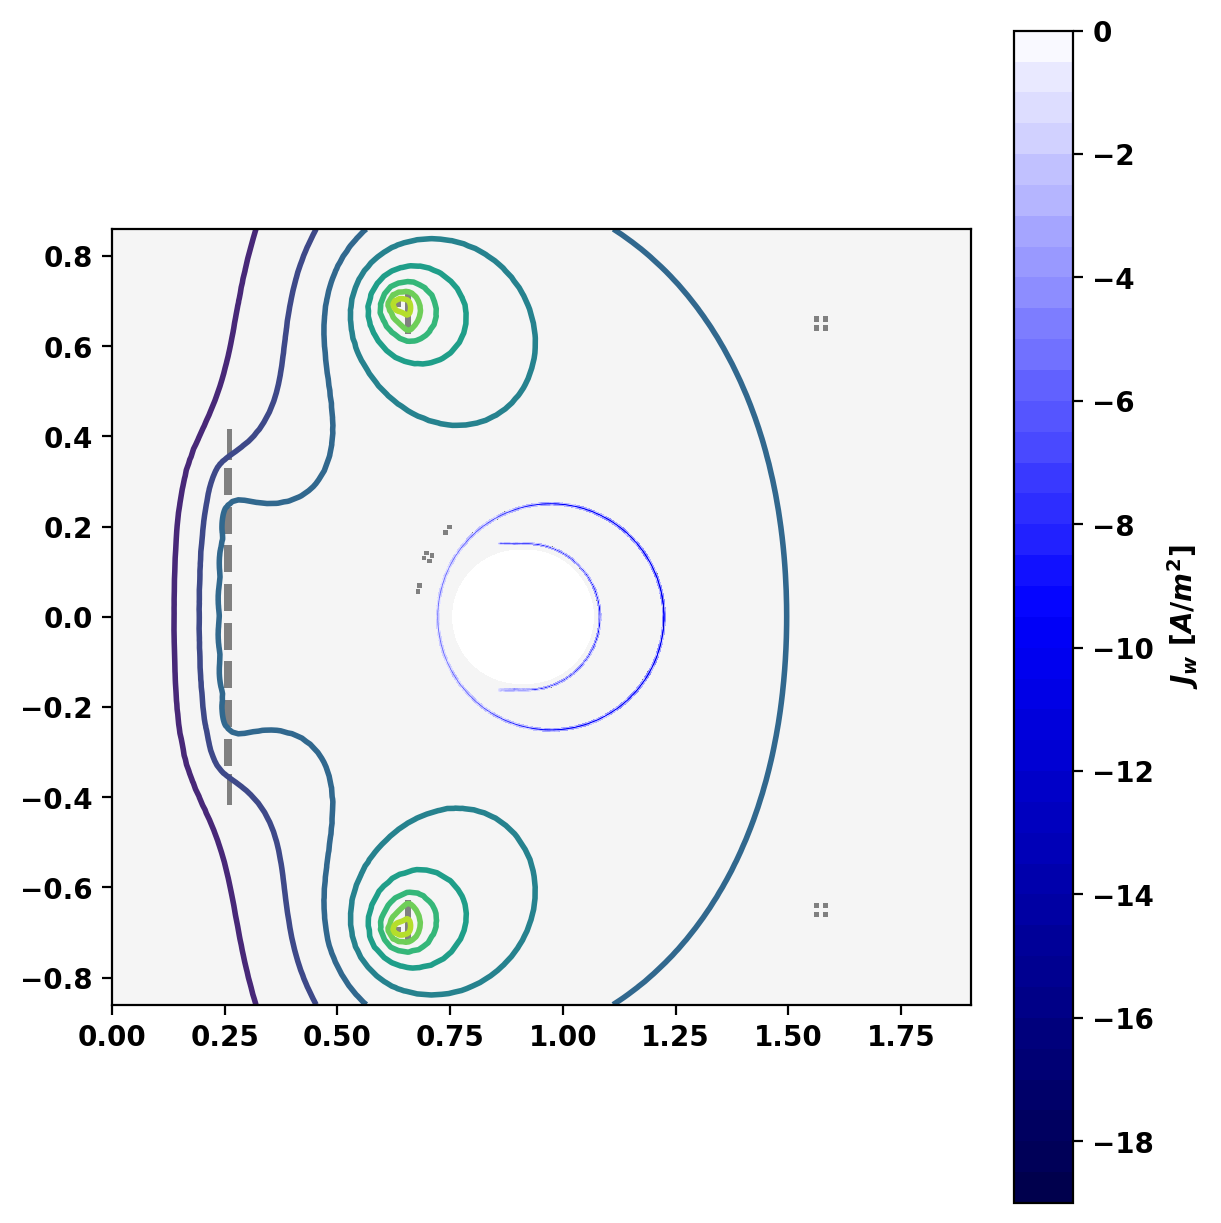

In [9]:
fig, ax = plt.subplots(1,1,constrained_layout=True)
# Plot flux evolution in time
mygs.plot_machine(fig,ax,coil_colormap=None,limiter_color=None)
mygs.plot_psi(fig,ax,psi=psi_new,normalized=False,plasma_nlevels=10,vacuum_levels=None,xpoint_color=None)
mygs.plot_eddy(fig,ax,psi=psi_new,colormap='seismic',symmap=True)